In [106]:
# Colab 사용시 실행

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
!pwd

/content/drive/My Drive/MedSAM_labeling


In [108]:
# Colab 사용시 실행

%cd /content/drive/My\ Drive/MedSAM_labeling

/content/drive/My Drive/MedSAM_labeling


In [109]:
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import torch
from skimage import io, transform
import torch.nn.functional as F
import argparse
import glob
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm
import gc

torch.cuda.empty_cache()

In [110]:
# Model load

MedSAM_CKPT_PATH = "weights/medsam_vit_b.pth"
# device = "cuda:1"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
# medsam_model = medsam_model.to(device)
mask_predictor = SamPredictor(medsam_model)

**txt파일이름 변경**

In [ ]:
import os
import glob

# 파일 이름 변경 함수
def rename_txt_files(directory):
    txt_files = glob.glob(os.path.join(directory, "*.txt"))

    if not txt_files:
        print("No txt files found in the directory.")
        return

    for file_path in txt_files:
        # 파일 이름과 확장자를 분리
        dir_name, file_name = os.path.split(file_path)
        name, ext = os.path.splitext(file_name)

        print(f"Processing file: {file_name}")

        # '_png' 앞까지만 남기기
        if "_png" in name:
            new_name = name.split("_png")[0] + ".txt"
            new_path = os.path.join(dir_name, new_name)
            os.rename(file_path, new_path)
            print(f'Renamed: {file_path} to {new_path}')
        else:
            print(f"No '_png' in {file_name}, skipping...")

# 실제 txt 파일들이 있는 디렉토리 경로로 변경
directory = "data/box/"
rename_txt_files(directory)

Processing file: 11_01_0001_X0Y0_040960_014336.txt
No '_png' in 11_01_0001_X0Y0_040960_014336.txt, skipping...
Processing file: 11_01_0001_X0Y0_043008_034816.txt
No '_png' in 11_01_0001_X0Y0_043008_034816.txt, skipping...


**image이름 변경**

In [ ]:
import os
import glob

# 파일 이름 변경 함수
def rename_jpg_files(directory):
    jpg_files = glob.glob(os.path.join(directory, "*.jpg"))

    if not jpg_files:
        print("No jpg files found in the directory.")
        return

    for file_path in jpg_files:
        # 파일 이름과 확장자를 분리
        dir_name, file_name = os.path.split(file_path)
        name, ext = os.path.splitext(file_name)

        print(f"Processing file: {file_name}")

        # '_png' 앞까지만 남기기
        if "_png" in name:
            new_name = name.split("_png")[0] + ".jpg"
            new_path = os.path.join(dir_name, new_name)
            os.rename(file_path, new_path)
            print(f'Renamed: {file_path} to {new_path}')
        else:
            print(f"No '_png' in {file_name}, skipping...")

# 실제 txt 파일들이 있는 디렉토리 경로로 변경
directory = "data/image/"
rename_jpg_files(directory)

Processing file: 11_01_0001_X0Y0_040960_014336_png.rf.10cfbbac2d16e264358c4f86b93bbe9e.jpg
Renamed: data/image/11_01_0001_X0Y0_040960_014336_png.rf.10cfbbac2d16e264358c4f86b93bbe9e.jpg to data/image/11_01_0001_X0Y0_040960_014336.jpg
Processing file: 11_01_0001_X0Y0_043008_034816_png.rf.10f38c4c985118489039a59cab669e5a.jpg
Renamed: data/image/11_01_0001_X0Y0_043008_034816_png.rf.10f38c4c985118489039a59cab669e5a.jpg to data/image/11_01_0001_X0Y0_043008_034816.jpg


**함수정의**

In [241]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import gc
from skimage import io

# Define colors for specific classes
class_colors = {
    0: (255, 0, 0),  # Red for class 0
    1: (0, 255, 0),  # Green for class 1
}

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    # box = [x_min, y_min, x_max, y_max]
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def modify_coords(bbox_list):
    boxes = []
    for bbox in bbox_list:
        x_center, y_center, w, h = bbox
        x_min = int(x_center - w / 2)
        y_min = int(y_center - h / 2)
        x_max = int(x_center + w / 2)
        y_max = int(y_center + h / 2)
        boxes.append([x_min, y_min, x_max, y_max])
    return boxes

def process_image(path, mask_predictor, batch_size=10):
    name = path.split('/')[-1].split('.')[0]
    image = cv2.imread(path)

    if image is None:
        print(f"Warning: Could not read image {path}")
        return None, None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_predictor.set_image(image)

    H, W, _ = image.shape

    bbox_list = []
    classes = []
    try:
        with open(f'data/box/{name}.txt') as file:
            for line in file:
                values = line.strip().split()
                bbox_list.append([int(float(value) * H) for value in values[1:]])
                classes.append([int(value) for value in values[0]])
    except FileNotFoundError:
        print(f"Warning: Could not read bbox file for {name}")
        return None, None

    bboxes = modify_coords(bbox_list)
    combined_mask = np.zeros((H, W), dtype=np.uint8)

    # 배치 처리
    for i in range(0, len(bboxes), batch_size):
        batch_boxes = bboxes[i:i + batch_size]
        batch_classes = classes[i:i + batch_size]
        input_boxes = torch.tensor(batch_boxes, device=mask_predictor.device)
        transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

        masks, _, _ = mask_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        for idx, mask in enumerate(masks):
            class_ = batch_classes[idx][0]
            mask_np = mask.cpu().numpy()[0]
            mask_binary = (mask_np > 0.5).astype(np.uint8) * (class_ + 1)
            combined_mask = np.maximum(combined_mask, mask_binary)

        del input_boxes, transformed_boxes, masks
        torch.cuda.empty_cache()
        gc.collect()

    io.imsave(f"data/mask/{name}.png", combined_mask)

    return image, combined_mask

# 원본사진 위에 segmentation된 것을 표시하는 함수
def visualize_image(image, combined_mask, path):
    if image is None or combined_mask is None:
        print(f"Error: Image or combined mask is None for {path}")
        return

    # Create a color map for the combined mask
    combined_mask_color = np.zeros((combined_mask.shape[0], combined_mask.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(combined_mask)

    # Apply predefined colors
    for cls in unique_classes:
        if cls == 0:
            color = class_colors.get(0, (0, 0, 255))  # Red for class 0
        elif cls == 1:
            color = class_colors.get(1, (0, 255, 0))  # Green for class 1
        else:
            continue  # Skip any other classes

        combined_mask_color[combined_mask == cls] = color

    # Blend the original image with the colored mask
    combined_image = cv2.addWeighted(image, 0.7, combined_mask_color, 0.3, 0)

    # Display the combined image
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.title('Image with Combined Mask')
    plt.show()

    # Save the combined image
    name = path.split('/')[-1].split('.')[0]
    combined_image_bgr = cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR)  # Convert to BGR for saving
    cv2.imwrite(f"data/c_mask/{name}_combined.png", combined_image_bgr)

# Combined mask와 함께 원본 이미지를 시각화하는 함수
def visualize_image_and_combined_mask(image, combined_mask, path):
    if image is None or combined_mask is None:
        print(f"Error: Image or combined mask is None for {path}")
        return

    # Create a color map for the combined mask
    combined_mask_color = np.zeros((combined_mask.shape[0], combined_mask.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(combined_mask)

    # Apply predefined colors
    for cls in unique_classes:
        if cls == 0:
            color = class_colors.get(0, (255, 0, 0))  # Red for class 0
        elif cls == 1:
            color = class_colors.get(1, (0, 255, 0))  # Green for class 1
        else:
            continue  # Skip any other classes

        combined_mask_color[combined_mask == cls] = color

    # Blend the original image with the colored mask
    combined_image = cv2.addWeighted(image, 0.7, combined_mask_color, 0.3, 0)

    # Display the original image, combined mask, and combined image side by side
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Combined mask
    axes[1].imshow(combined_mask, cmap='jet')
    axes[1].axis('off')
    axes[1].set_title('Combined Mask')

    # Combined image
    axes[2].imshow(combined_image)
    axes[2].axis('off')
    axes[2].set_title('Image with Combined Mask')

    plt.show()

    # Save the combined image
    name = path.split('/')[-1].split('.')[0]
    combined_image_bgr = cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR)  # Convert to BGR for saving
    cv2.imwrite(f"data/c_mask/{name}_combined.png", combined_image_bgr)

def outlier(image, combined_mask, path):
    if image is None or combined_mask is None:
        print(f"Error: Image or combined mask is None for {path}")
        return

    # Create a copy of the original image to draw contours on
    image_with_contour = image.copy()

    # Find contours for each unique class in the combined mask
    unique_classes = np.unique(combined_mask)
    for cls in unique_classes:
        if cls == 0:
            continue  # Skip background

        # Create a binary mask for the current class
        class_mask = np.uint8(combined_mask == cls)

        # Find contours for the current class
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Determine color for the current class
        color = class_colors.get(cls, (0, 255,0 )) #이걸로 outlier색바꿈

        # Draw contours on the image
        cv2.drawContours(image_with_contour, contours, -1, color, 12)  # Thickness 12

    # Convert image with contours to BGR for saving
    image_with_contour_bgr = cv2.cvtColor(image_with_contour, cv2.COLOR_RGB2BGR)

    # Save the image with contours
    name = path.split('/')[-1].split('.')[0]
    cv2.imwrite(f"data/outlier/{name}.png", image_with_contour_bgr)

    return image_with_contour_bgr

def read_bboxes_from_txt(txt_path):
    bboxes = []
    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            bbox = list(map(float, line.strip().split()))
            bboxes.append(bbox)
    return bboxes

def bbox_image(image, bboxes, path):
    if image is None or bboxes is None:
        print(f"Error: Image or bounding boxes are None for {path}")
        return

    # Create a copy of the original image to draw bounding boxes on
    image_with_bboxes = image.copy()

    height, width = image.shape[:2]

    # Draw bounding boxes on the image
    for bbox in bboxes:
        cls_id, x_center, y_center, bbox_width, bbox_height = bbox
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height

        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)

        color = class_colors.get(int(cls_id), (0, 255, 0))  # Green for class 1

        # Draw the bounding box
        cv2.rectangle(image_with_bboxes, (x1, y1), (x2, y2), color, 12)

    # Display the image with bounding boxes without padding and white borders
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0, 0, 1, 1])  # Add axes that fill the figure
    ax.imshow(image_with_bboxes)
    ax.axis('off')
    plt.show()

    # Save the image with bounding boxes
    name = path.split('/')[-1].split('.')[0]
    image_with_bboxes_bgr = cv2.cvtColor(image_with_bboxes, cv2.COLOR_RGB2BGR)  # Convert to BGR for saving
    cv2.imwrite(f"data/bbox_image/{name}.png", image_with_bboxes_bgr)



**테두리+바운딩박스**

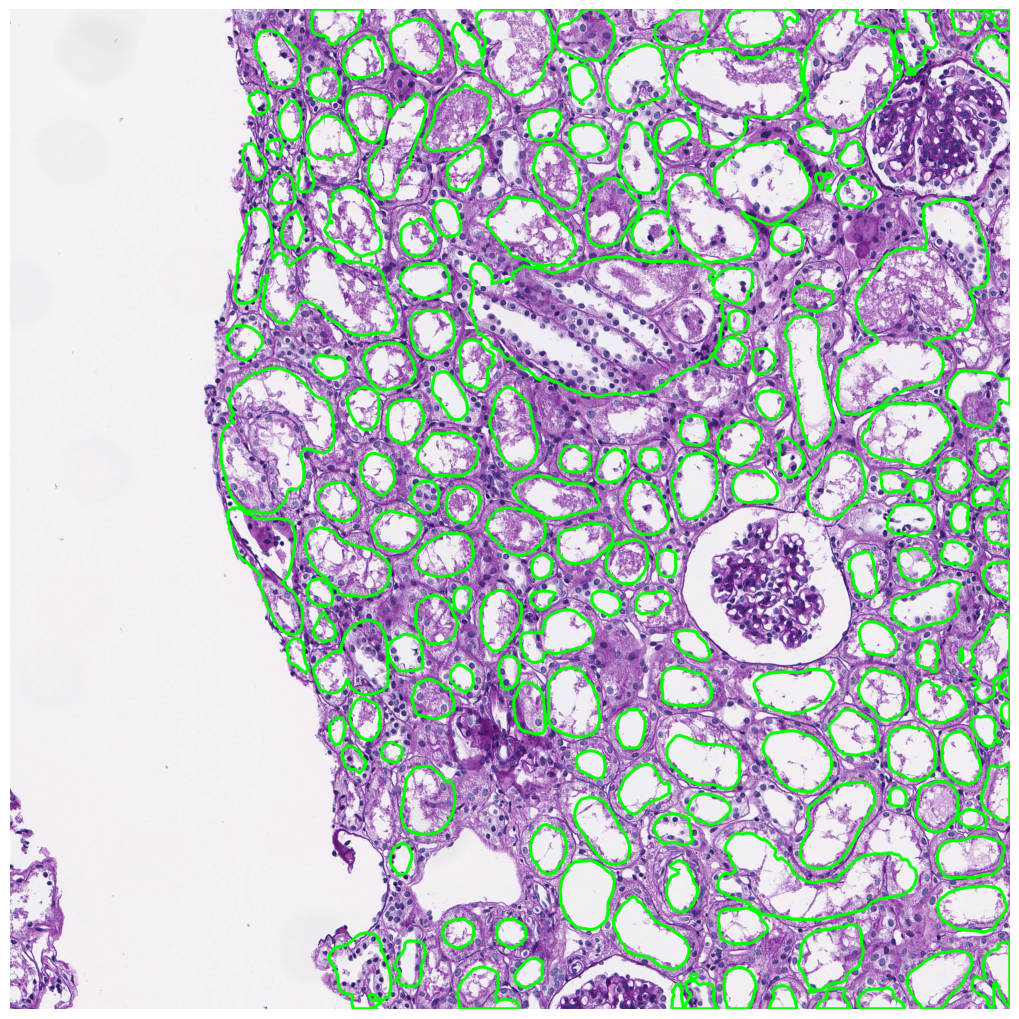

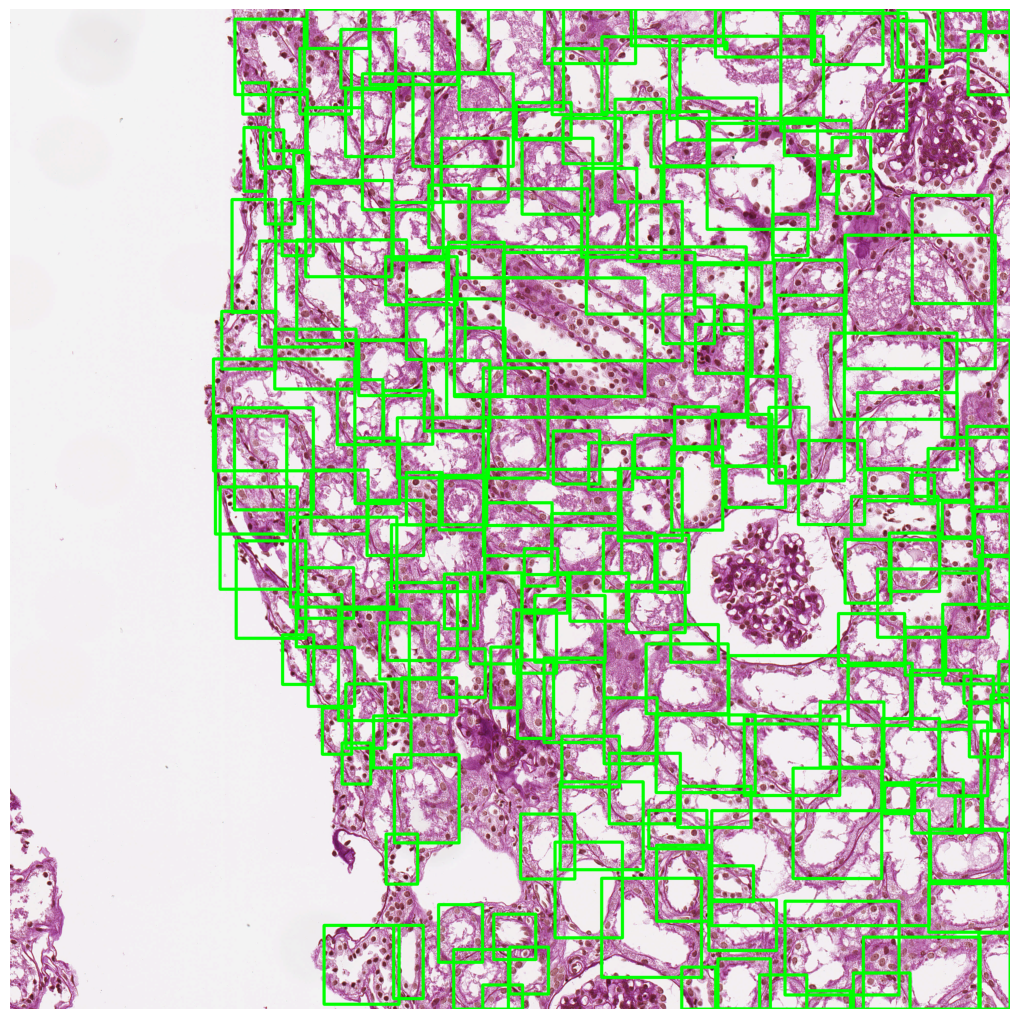

In [242]:
# Example usage
image = cv2.imread('data/image/11_01_0001_X0Y0_040960_014336.png')
combined_mask = cv2.imread('data/mask/11_01_0001_X0Y0_040960_014336.png', 0)  # Load mask as grayscale

outlier_image = outlier(image, combined_mask, 'data/mask/11_01_0001_X0Y0_040960_014336.png')
if outlier_image is not None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0, 0, 1, 1])  # Add axes that fill the figure
    ax.imshow(outlier_image)
    ax.axis('off')
    plt.show()

# Assuming the txt file path and image path are provided
txt_path = 'data/box/11_01_0001_X0Y0_040960_014336.txt'
image_path = 'data/image/11_01_0001_X0Y0_040960_014336.png'

# Read bounding boxes from txt file
bboxes = read_bboxes_from_txt(txt_path)

# Read the image
image = cv2.imread(image_path)

# Visualize the image with bounding boxes
bbox_image(image, bboxes, image_path)

**원본&마스크만&전체그림 테두리**

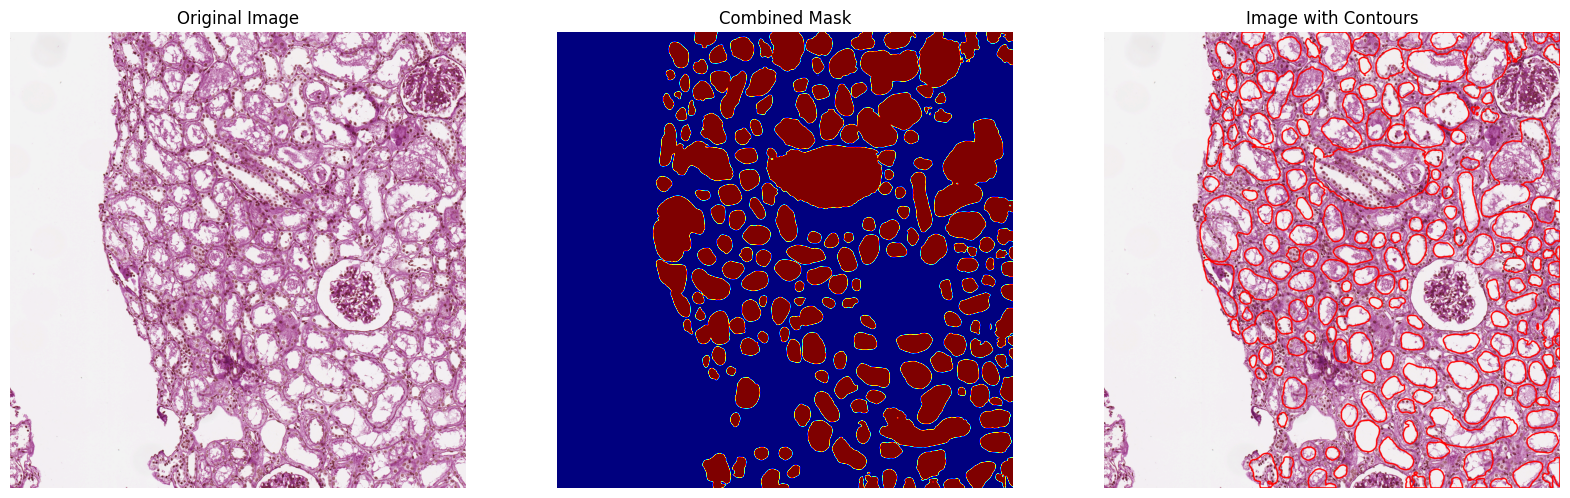

In [216]:
# 예제 사용법
image = cv2.imread('data/image/11_01_0001_X0Y0_040960_014336.png')
combined_mask = cv2.imread('data/mask/11_01_0001_X0Y0_040960_014336.png', 0)  # Load mask as grayscale
visualize_image_with_contour(image, combined_mask, 'data/image/11_01_0001_X0Y0_040960_014336.png')

**원본 & 마스크만 시각화 & 원본위에 마스크**

<ipython-input-117-6cc611ff7576>:87: UserWarning: data/mask/11_01_0001_X0Y0_040960_014336.png is a low contrast image
  io.imsave(f"data/mask/{name}.png", combined_mask)


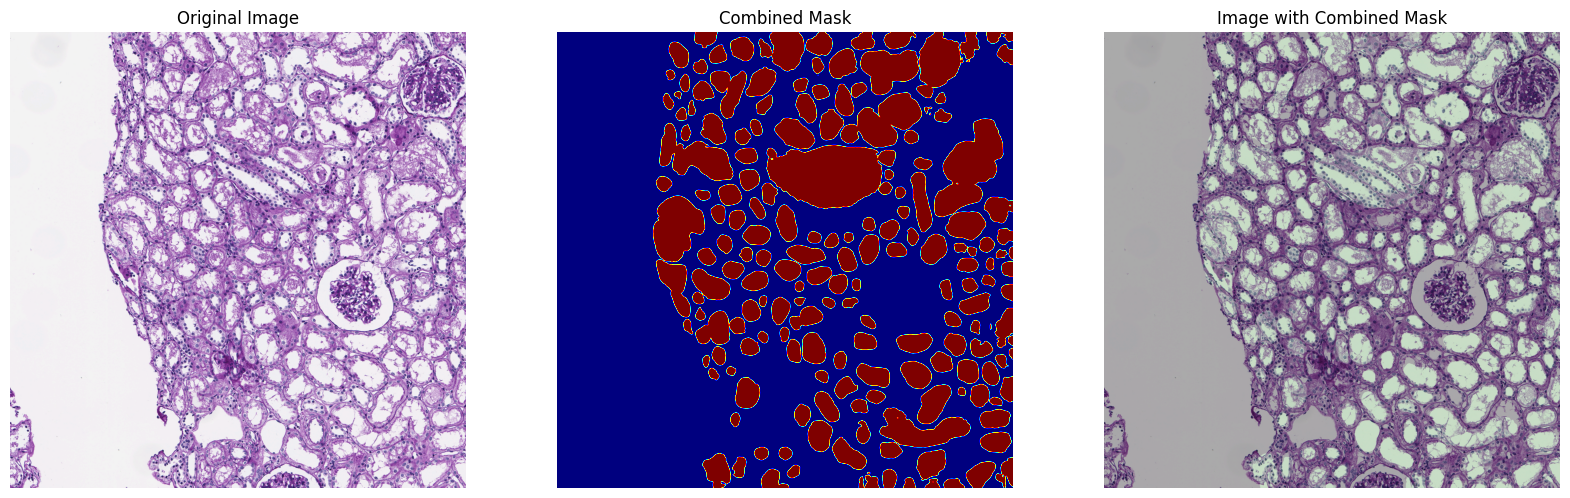

In [119]:
path = 'data/image/11_01_0001_X0Y0_040960_014336.png'
image, combined_mask = process_image(path, mask_predictor, batch_size=10)
visualize_image_and_combined_mask(image, combined_mask, path)

**원본 위에 마스크**

<ipython-input-5-f4fdd26cb9a4>:87: UserWarning: data/mask/11_01_0001_X0Y0_040960_014336.jpg is a low contrast image
  io.imsave(f"data/mask/{name}.jpg", combined_mask)


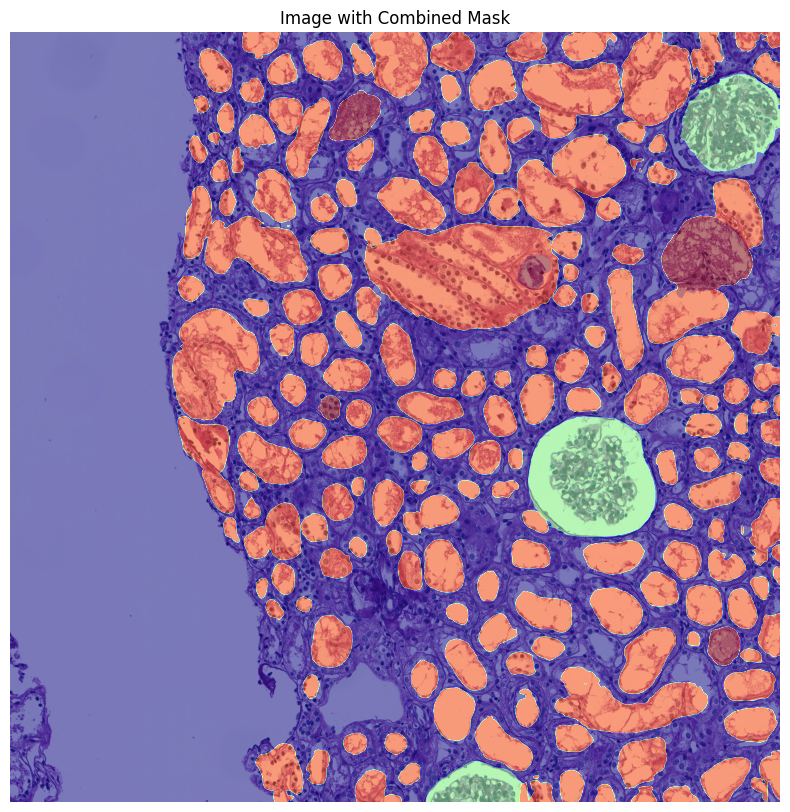

In [ ]:
import matplotlib.pyplot as plt

# 이미지 경로
path = 'data/image/11_01_0001_X0Y0_040960_014336.'

# 이미지와 combined mask 생성
image, combined_mask = process_image(path, mask_predictor, batch_size=10)

# 이미지와 combined mask 시각화 함수
def image_plus_combined_mask(image, combined_mask, path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.imshow(combined_mask, cmap='jet', alpha=0.5)  # combined mask를 반투명하게 오버레이
    ax.set_title('Image with Combined Mask')
    ax.axis('off')
    plt.show()

# 이미지와 combined mask 시각화
image_plus_combined_mask(image, combined_mask, path)

**c_mask만 시각화**

<ipython-input-5-f4fdd26cb9a4>:87: UserWarning: data/mask/11_01_0001_X0Y0_040960_014336.jpg is a low contrast image
  io.imsave(f"data/mask/{name}.jpg", combined_mask)


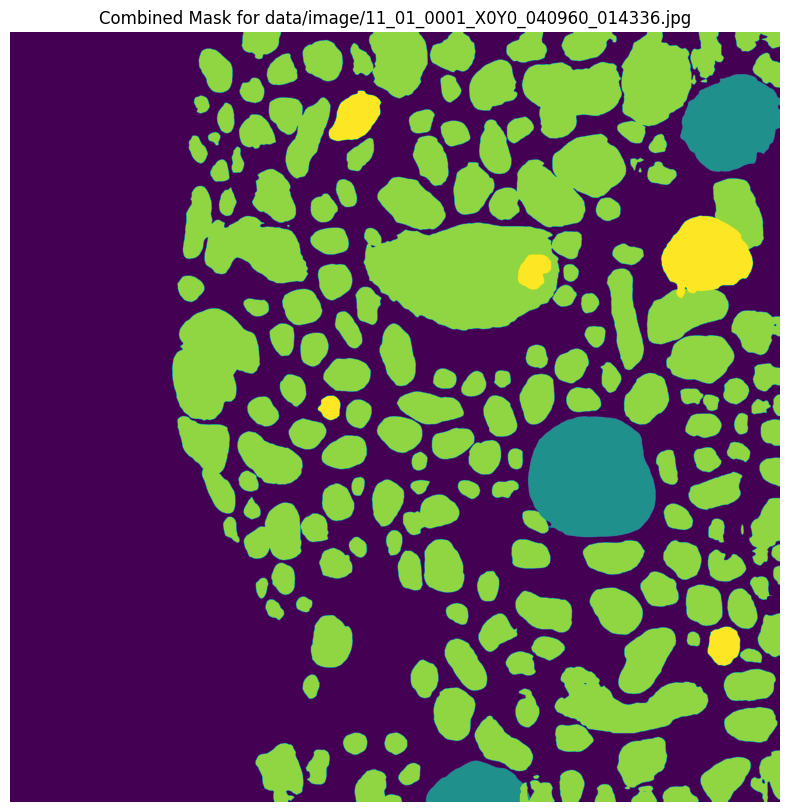

In [ ]:
# 이미지 경로
path = 'data/image/11_01_0001_X0Y0_040960_014336.jpg'

# 이미지와 combined mask 생성
image, combined_mask = process_image(path, mask_predictor, batch_size=10)

# combined mask 시각화 함수
def visualize_combined_mask(mask, path):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # 마스크 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(mask)
    plt.title(f'Combined Mask for {path}')
    plt.axis('off')
    plt.show()

# combined mask 시각화
visualize_combined_mask(combined_mask, path)


**함수 수행**

In [ ]:
#이미지랑 마스크 옆에 비교해서 보여주기
img_pathes = ['data/image/11_01_0001_X0Y0_040960_014336.jpg']

# 이미지를 부분적으로 처리
for i, path in enumerate(tqdm(img_pathes)):
    process_image(path, mask_predictor)

  0%|          | 0/1 [00:00<?, ?it/s]

[[2], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [2], [4], [4], [5], [4], [4], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [2], [4], [4], [4],